In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
ROOT = Path().resolve().parent  
DATA = ROOT / "data" / "interim" / "bank_customers_clean.pandas.parquet"

df = pd.read_parquet(DATA)
df.head()


,ID,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,term_deposit,label
0,1,58,management,2,tertiary,0,2143,1,0,5,may,261,1,-1,0,0,0
1,2,44,technician,1,secondary,0,29,1,0,5,may,151,1,-1,0,0,0
2,3,33,entrepreneur,2,secondary,0,2,1,1,5,may,76,1,-1,0,0,0
3,4,47,blue-collar,2,unknown,0,1506,1,0,5,may,92,1,-1,0,0,0
4,5,33,unknown,1,unknown,0,1,0,0,5,may,198,1,-1,0,0,0


In [3]:
df.info()

print("\nUnique ID:", df["ID"].nunique(), " / rows:", len(df))
print("\nLabel rate:", df["label"].mean())
print("\nLabel counts:\n", df["label"].value_counts())

# Missing check
missing = df.isna().sum()
missing[missing > 0].sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42639 entries, 0 to 42638
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            42639 non-null  int64 
 1   age           42639 non-null  Int64 
 2   job           42639 non-null  object
 3   marital       42639 non-null  int64 
 4   education     42639 non-null  object
 5   default       42639 non-null  int64 
 6   balance       42639 non-null  int64 
 7   housing       42639 non-null  int64 
 8   loan          42639 non-null  int64 
 9   day           42639 non-null  int64 
 10  month         42639 non-null  object
 11  duration      42639 non-null  int64 
 12  campaign      42639 non-null  int64 
 13  pdays         42639 non-null  int64 
 14  previous      42639 non-null  int64 
 15  term_deposit  42639 non-null  int64 
 16  label         42639 non-null  int64 
dtypes: Int64(1), int64(13), object(3)
memory usage: 5.6+ MB

Unique ID: 42639  / rows: 42639

Series([], dtype: int64)

Data khá sạch, không có missing values tuy nhiên phân phối lớp bị lệch khoảng 9.29%

In [4]:
# pdays = -1 nghĩa là chưa từng contact trước đó
df["pdays_is_missing"] = (df["pdays"] == -1).astype(int)

# balance có thể âm -> log1p chỉ áp dụng phần >=0 để xem phân phối
df["balance_pos"] = df["balance"].clip(lower=0)
df["balance_log1p"] = np.log1p(df["balance_pos"])

# bins để nhìn conversion theo nhóm
df["age_bin"] = pd.cut(df["age"], bins=[17,25,35,45,55,65,100])
df["balance_bin"] = pd.qcut(df["balance"], q=10, duplicates="drop")  # deciles
df["campaign_bin"] = pd.cut(df["campaign"], bins=[0,1,2,3,5,10,100], include_lowest=True)

# duration thường gây leakage (biết sau cuộc gọi), nhưng dùng để phân tích post-call
df["duration_bin"] = pd.cut(df["duration"], bins=[-1,0,60,120,180,300,600,1200,5000])


In [9]:
def conv_table(col, min_n=200, top=15):
    t = (df.groupby(col)["label"]
           .agg(n="count", conversion="mean")
           .sort_values(["conversion","n"], ascending=[False, False]))
    if min_n is not None:
        t = t[t["n"] >= min_n]
    return t.head(top)

def plot_conv_bar(t, title):
    plt.figure()
    plt.bar(t.index.astype(str), t["conversion"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Conversion rate")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [6]:
num_cols = ["age","balance","duration","campaign","pdays","previous","day"]
df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
age,42639.0,40.788808,10.200236,18.0,33.0,39.0,48.0,95.0
balance,42639.0,1331.863951,3011.537676,-8019.0,62.0,429.0,1381.5,102127.0
duration,42639.0,255.957504,258.361368,0.0,101.0,177.0,315.0,4918.0
campaign,42639.0,2.816412,3.163564,1.0,1.0,2.0,3.0,63.0
pdays,42639.0,34.169141,92.041713,-1.0,-1.0,-1.0,-1.0,536.0
previous,42639.0,0.465442,2.166705,0.0,0.0,0.0,0.0,275.0
day,42639.0,15.854781,8.293901,1.0,8.0,16.0,21.0,31.0


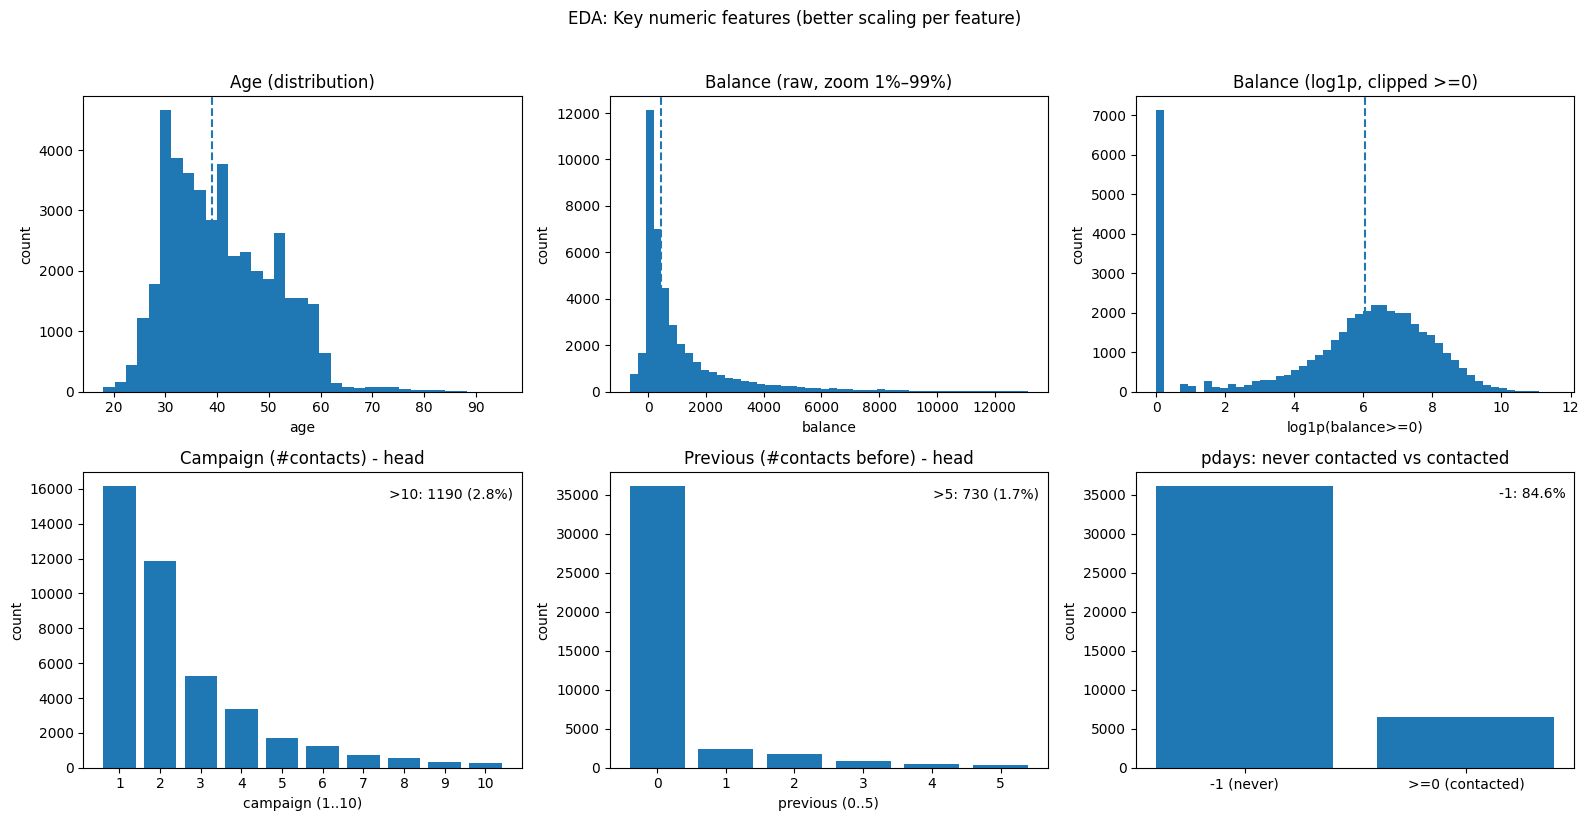

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_numeric_eda(df):
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    ax = axes.ravel()

    # ---------- 1) Age ----------
    age = df["age"].dropna()
    ax0 = ax[0]
    ax0.hist(age, bins=35)
    ax0.axvline(age.median(), linestyle="--")
    ax0.set_title("Age (distribution)")
    ax0.set_xlabel("age")
    ax0.set_ylabel("count")

    # ---------- 2) Balance (raw, zoom to p99) ----------
    bal = df["balance"].dropna()
    p99 = bal.quantile(0.99)
    bal_zoom = bal[(bal >= bal.quantile(0.01)) & (bal <= p99)]

    ax1 = ax[1]
    ax1.hist(bal_zoom, bins=50)
    ax1.axvline(bal_zoom.median(), linestyle="--")
    ax1.set_title("Balance (raw, zoom 1%–99%)")
    ax1.set_xlabel("balance")
    ax1.set_ylabel("count")

    # ---------- 3) Balance log1p (non-negative) ----------
    bal_pos = bal.clip(lower=0)
    bal_log = np.log1p(bal_pos)

    ax2 = ax[2]
    ax2.hist(bal_log, bins=50)
    ax2.axvline(np.median(bal_log), linestyle="--")
    ax2.set_title("Balance (log1p, clipped >=0)")
    ax2.set_xlabel("log1p(balance>=0)")
    ax2.set_ylabel("count")

    # ---------- 4) Campaign (bar for small counts) ----------
    camp = df["campaign"].dropna().astype(int)
    # show 1..10 clearly, aggregate tail
    max_show = 10
    counts = camp.value_counts().sort_index()
    head = counts[counts.index <= max_show]
    tail = counts[counts.index > max_show].sum()

    ax3 = ax[3]
    ax3.bar(head.index.astype(str), head.values)
    ax3.set_title("Campaign (#contacts) - head")
    ax3.set_xlabel("campaign (1..10)")
    ax3.set_ylabel("count")
    # annotate tail
    ax3.text(0.98, 0.95, f">{max_show}: {tail} ({tail/len(camp):.1%})",
             transform=ax3.transAxes, ha="right", va="top")

    # ---------- 5) Previous (bar for small counts) ----------
    prev = df["previous"].dropna().astype(int)
    max_show_prev = 5
    counts_p = prev.value_counts().sort_index()
    head_p = counts_p[counts_p.index <= max_show_prev]
    tail_p = counts_p[counts_p.index > max_show_prev].sum()

    ax4 = ax[4]
    ax4.bar(head_p.index.astype(str), head_p.values)
    ax4.set_title("Previous (#contacts before) - head")
    ax4.set_xlabel("previous (0..5)")
    ax4.set_ylabel("count")
    ax4.text(0.98, 0.95, f">{max_show_prev}: {tail_p} ({tail_p/len(prev):.1%})",
             transform=ax4.transAxes, ha="right", va="top")

    # ---------- 6) pdays (special: -1 vs others) ----------
    pdays = df["pdays"].dropna().astype(int)
    miss = (pdays == -1).sum()
    non = (pdays != -1).sum()

    ax5 = ax[5]
    ax5.bar(["-1 (never)", ">=0 (contacted)"], [miss, non])
    ax5.set_title("pdays: never contacted vs contacted")
    ax5.set_ylabel("count")
    ax5.text(0.98, 0.95, f"-1: {miss/len(pdays):.1%}",
             transform=ax5.transAxes, ha="right", va="top")

    fig.suptitle("EDA: Key numeric features (better scaling per feature)", y=1.02)
    fig.tight_layout()
    plt.show()


plot_numeric_eda(df)



1) Age (distribution)

- Tập trung mạnh ở 30–45 tuổi, đỉnh khoảng đầu 30s → đây là nhóm “core customer base”.

- Phân phối lệch phải: sau 45 giảm dần, đuôi kéo dài đến ~90+ → nhóm cao tuổi ít, có thể là niche segment.

-> cần xem conversion theo age_bin (30–45 đông nhưng chưa chắc hiệu quả nhất).

2) Balance (raw, zoom 1%–99%)

- Balance lệch phải rất mạnh: đa số nằm vùng thấp–trung bình, một số ít có balance rất cao (đuôi dài).

- Có giá trị âm (overdraft/chi phí/ghi nợ) → không thể log trực tiếp toàn bộ.

-> dùng log1p(balance>=0) hoặc bin theo quantile để phân tích conversion và để model ổn định.

3) Balance (log1p, clipped >=0)

- Sau log1p, phân phối trở nên “dễ nhìn” và gần dạng chuông hơn, thể hiện rõ cấu trúc nhóm khách có tiền.

- Có cột spike ở 0 (nhiều người balance <= 0 sau clip) → đây là segment riêng (low/negative balance).

-> tách nhóm balance<=0 như một segment; kiểm tra conversion của nhóm này có thấp rõ rệt không.

4) Campaign (#contacts) – head (1..10) + tail

- Phần lớn khách hàng được gọi 1–3 lần, giảm mạnh sau đó; >10 chỉ ~2.8%.

-> có dấu hiệu “diminishing returns” — gọi quá nhiều lần chỉ chiếm ít, có thể gây lãng phí/phiền khách.


5) Previous (#contacts before) – head (0..5) + tail

Phần lớn = 0: đa số khách chưa từng được liên hệ trước (trong history).

>5 chỉ ~1.7% → nhóm “đã từng được contact nhiều” rất nhỏ.

6) pdays: never contacted vs contacted

~84.6% có pdays = -1 ⇒ đa số chưa từng contact trước đó (cold segment).

Nhóm đã từng contact chỉ ~15.4% nhưng thường là nhóm “warm/known”.


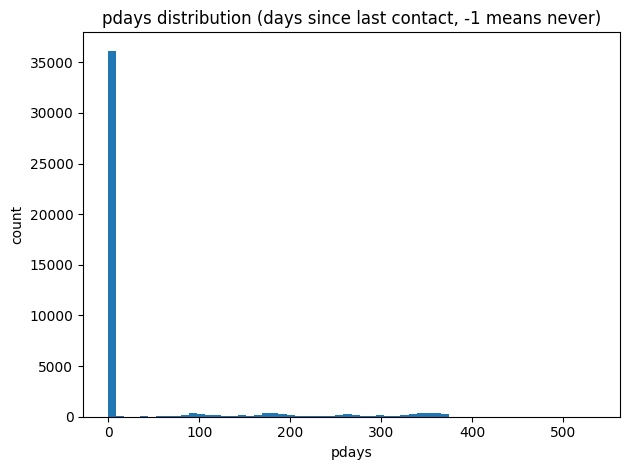

pdays
-1      36082
 370       96
 364       75
 350       72
 175       67
 183       66
 343       64
 349       56
 182       55
 189       52
Name: count, dtype: int64

In [11]:
plt.figure()
plt.hist(df["pdays"], bins=60)
plt.title("pdays distribution (days since last contact, -1 means never)")
plt.xlabel("pdays")
plt.ylabel("count")
plt.tight_layout()
plt.show()

df["pdays"].value_counts().head(10)


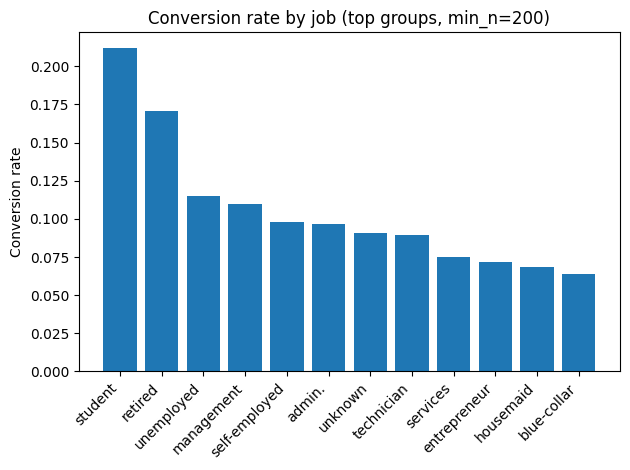

In [12]:
t_job = conv_table("job", min_n=200, top=15)
t_job
plot_conv_bar(t_job, "Conversion rate by job (top groups, min_n=200)")


student cao nhất (~0.21)

retired đứng thứ 2 (~0.17)

các nhóm tiếp theo như unemployed / management / self-employed / admin quanh ~0.10–0.12

các nhóm thấp hơn như services / entrepreneur / housemaid / blue-collar khoảng ~0.06–0.08

-> Nếu call budget hạn chế: ưu tiên nhóm student + retired (conversion cao hơn baseline 9.3% rất nhiều).

Nhóm blue-collar / housemaid / entrepreneur conversion thấp hơn ⇒ cần thay đổi offer/script hoặc chỉ target khi có tín hiệu tốt khác (balance cao, warm lead…).

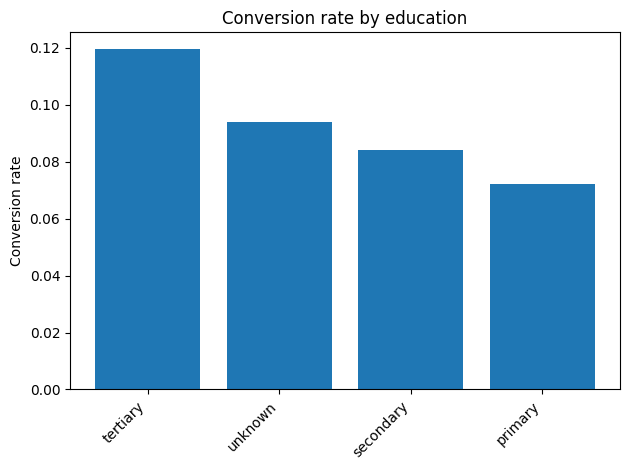

In [13]:
t_edu = conv_table("education", min_n=200, top=20)
t_edu
plot_conv_bar(t_edu, "Conversion rate by education")


Tertiary cao nhất (~12%), rồi đến unknown (~9–10%), secondary (~8–9%), primary thấp nhất (~7%).
→  ưu tiên target nhóm tertiary trong cùng ngân sách gọi.

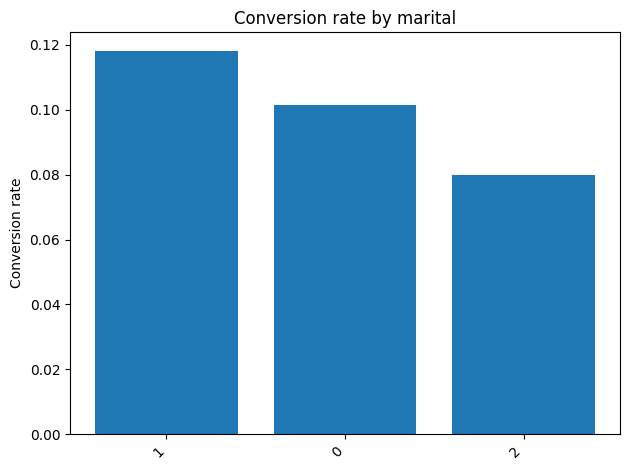

In [14]:
t_mar = conv_table("marital", min_n=200, top=20)
t_mar
plot_conv_bar(t_mar, "Conversion rate by marital")



 housing


,n,conversion
housing,,
0,18049,0.126766
1,24590,0.068036


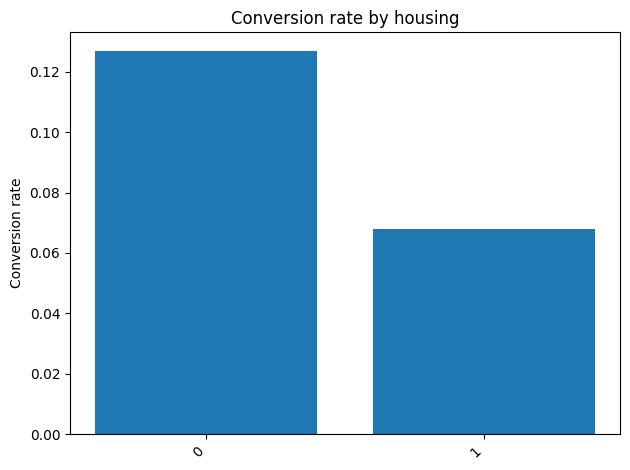


 loan


,n,conversion
loan,,
0,35554,0.099426
1,7085,0.060127


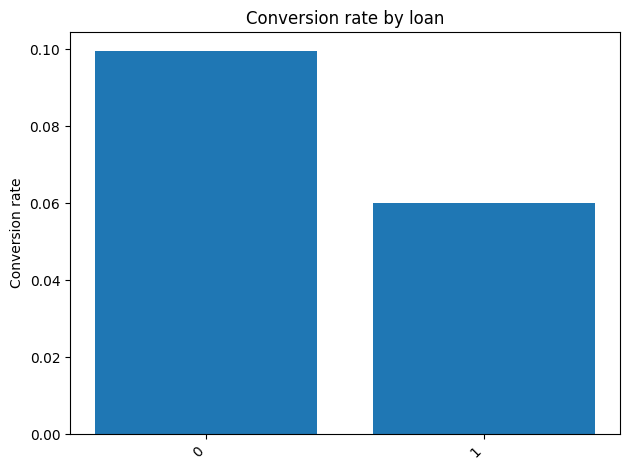


 default


,n,conversion
default,,
0,41828,0.093478
1,811,0.062885


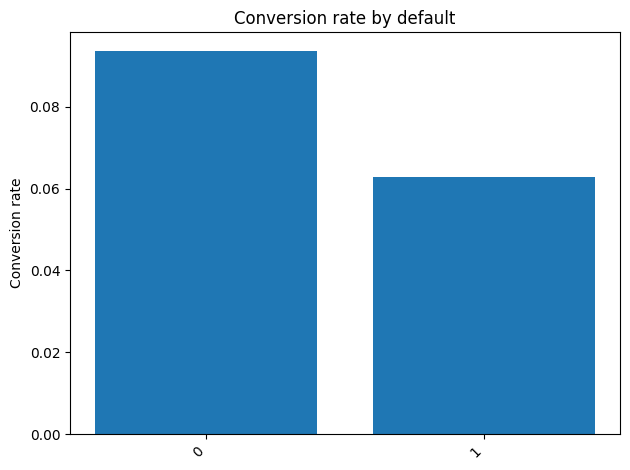

In [15]:
for c in ["housing", "loan", "default"]:
    t = conv_table(c, min_n=200, top=10)
    print("\n", c)
    display(t)
    plot_conv_bar(t, f"Conversion rate by {c}")


housing=0 conversion ~12–13%, housing=1 ~6–7% ⇒ chênh rất lớn (gần gấp đôi). loan=0 ~10%, loan=1 ~6% ⇒ có personal loan chuyển đổi thấp hơn rõ. default=0 ~9%+, default=1 ~6%+ ⇒ default cao thì conversion thấp.
→ khách không có housing loan dễ gửi term deposit hơn (ít áp lực nợ nhà): segment “no housing loan” là nhóm ưu tiên.


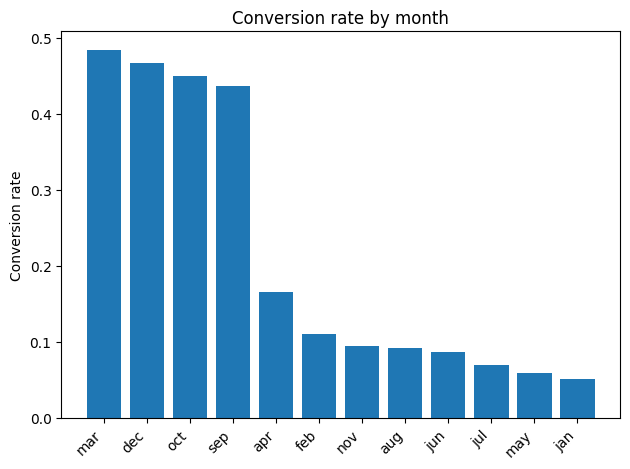

In [16]:
t_month = conv_table("month", min_n=200, top=20)
t_month
plot_conv_bar(t_month, "Conversion rate by month")


In [19]:
month_stats = df.groupby("month")["label"].agg(n="count", conversion="mean").sort_values("conversion", ascending=False)
month_stats


,n,conversion
month,,
mar,258,0.484496
dec,214,0.467290
oct,518,0.449807
sep,282,0.436170
apr,2718,0.165931
feb,2296,0.111063
nov,3895,0.094223
aug,5987,0.092200
jun,5128,0.086193


Sep/Oct/Dec/Mar là “golden months”, đây là nhóm tháng có conversion gấp ~4.7–5.2 lần baseline (xấp xỉ, vì 0.45/0.093).
-> nếu có thể chọn thời điểm chạy chiến dịch term-deposit, ưu tiên rollout / push budget vào Sep–Oct–Dec–Mar.

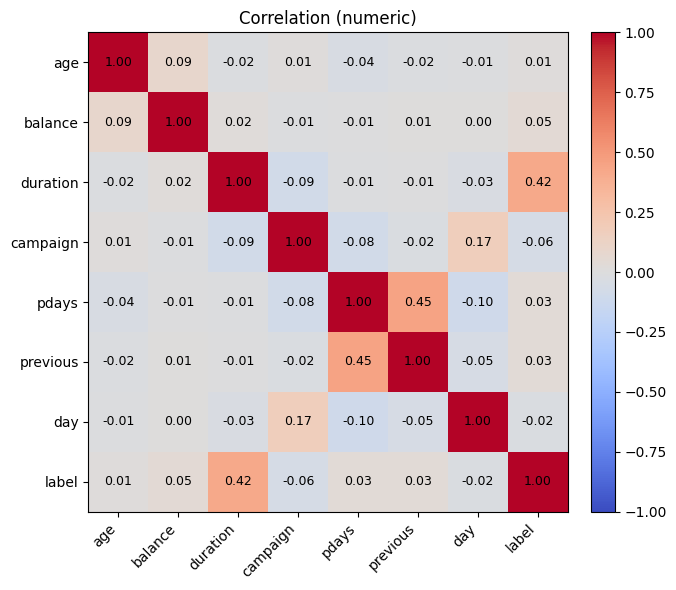

In [ ]:
num_cols = ["age","balance","duration","campaign","pdays","previous","day","label"]
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(7, 6))
im = plt.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")

plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation (numeric)")

# annotate values
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.values[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()



In [20]:
baseline = df["label"].mean()

def segment_report(filters, name):
    sub = df.query(filters)
    return {
        "segment": name,
        "filters": filters,
        "n": len(sub),
        "conversion": sub["label"].mean() if len(sub) else np.nan,
        "lift_vs_baseline": (sub["label"].mean() / baseline) if len(sub) else np.nan
    }

segments = []
segments.append(segment_report("month in ['sep','oct','dec','mar']", "Peak months"))
segments.append(segment_report("pdays_is_missing==0", "Warm leads (pdays>=0)"))
segments.append(segment_report("loan==0 and housing==0", "No loan & no housing loan"))
segments.append(segment_report("education=='tertiary'", "Education: tertiary"))
segments.append(segment_report("month in ['may','jan','jul']", "Low months"))

pd.DataFrame(segments).sort_values("lift_vs_baseline", ascending=False)


,segment,filters,n,conversion,lift_vs_baseline
0,Peak months,"month in ['sep','oct','dec','mar']",1272,0.456761,4.916898
1,Warm leads (pdays>=0),pdays_is_missing==0,6557,0.148544,1.599028
2,No loan & no housing loan,loan==0 and housing==0,15247,0.137994,1.485469
3,Education: tertiary,education=='tertiary',12302,0.119493,1.286304
4,Low months,"month in ['may','jan','jul']",21343,0.061519,0.662234


Nhận xét 
1. Seasonality là driver mạnh nhất

Peak months (Sep/Oct/Dec/Mar): conversion 45.7%, lift 4.92× baseline (n=1,272).
→ Chỉ riêng “đúng tháng” đã tăng hiệu quả gần 5 lần.

2. Warm leads tốt hơn baseline rõ rệt

Warm (pdays>=0): conversion 14.85%, lift 1.60× (n=6,557).
→ Retarget/warm lead hiệu quả hơn cold lead.

3. Tín hiệu tài chính: không có loan/housing loan là nhóm rất ngon

No loan & no housing loan: conversion 13.80%, lift 1.49× (n=15,247).
→ Nhóm ít gánh nợ dễ chốt hơn.

4. Education tertiary có hiệu quả nhưng không mạnh bằng 2 tín hiệu trên

Tertiary: conversion 11.95%, lift 1.29× (n=12,302).
→ Dùng như “tín hiệu phụ” trong scoring.

5. Low months thật sự là “mùa xấu”

Low months (May/Jan/Jul): conversion 6.15%, lift 0.66× (n=21,343).
→ Nếu gọi dàn trải vào các tháng này sẽ tốn budget.

# KẾT LUẬN
A) Lập lịch chiến dịch theo mùa (Strategy)

Peak months: mở rộng target (lower threshold), tăng call volume vì base conversion đã cao (45.7%).

Low months: giảm call volume, chỉ gọi “high-probability segments” hoặc top-score; chuyển bớt ngân sách sang kênh khác (push/email).

B) Rule-based targeting (khi chưa có model)

Ưu tiên gọi theo thứ tự:

Peak months (lift ~4.9×)

Nếu không phải peak months: ưu tiên Warm leads (pdays>=0) (lift ~1.6×)

Trong mỗi nhóm: ưu tiên thêm No loan & no housing loan (lift ~1.49×)

Tertiary là signal cộng điểm thêm (lift ~1.29×)

C) Với model (bước kế tiếp)

- Xây pre-call model (không dùng duration) để tạo score.

- Thiết kế policy:

    - Peak months: gọi top X% lớn hơn (ví dụ 30–40%)

    - Low months: gọi top X% nhỏ hơn (ví dụ 5–10%)

- Đánh giá bằng Lift@K / Precision@K 

In [21]:
baseline = df["label"].mean()

def seg(q, name):
    sub = df.query(q)
    return name, len(sub), sub["label"].mean(), sub["label"].mean()/baseline

tests = [
    ("month in ['sep','oct','dec','mar'] and pdays_is_missing==0", "Peak + Warm"),
    ("month in ['sep','oct','dec','mar'] and loan==0 and housing==0", "Peak + NoLoans"),
    ("pdays_is_missing==0 and loan==0 and housing==0", "Warm + NoLoans"),
    ("month in ['may','jan','jul'] and pdays_is_missing==0", "Low + Warm"),
]
pd.DataFrame([seg(q,n) for q,n in tests], columns=["segment","n","conversion","lift"])


,segment,n,conversion,lift
0,Peak + Warm,468,0.510684,5.497360
1,Peak + NoLoans,944,0.462924,4.983238
2,Warm + NoLoans,1580,0.318987,3.433805
3,Low + Warm,2791,0.084558,0.910237


A) Prioritization rule (khi chưa có model)

Peak + Warm (lift 5.5×)

Peak + NoLoans (lift 5.0×)

Warm + NoLoans (lift 3.4×)

Các nhóm còn lại → chỉ gọi nếu có thêm tín hiệu mạnh (balance cao, job tốt…)

B) Budget phân bổ theo mùa

Peak months: gọi rộng (vì base conversion quá cao).

Low months: gọi hẹp và “chọn lọc” (vì kể cả warm cũng không tốt).